In [1]:
%matplotlib notebook

from os import listdir
from os.path import isfile, join
import json
import tensorflow
import numpy
import pandas
import matplotlib.pyplot as pyplot
import re
from matplotlib.lines import Line2D
from pprint import pprint
# import seaborn
# sns.set_theme()
numpy.set_printoptions(threshold=10000)
pyplot.rcParams['figure.figsize'] = 10, 8

In [2]:
def loadLogfiles(path):
    results = []
    files = (f for f in listdir(path) if f.endswith('.json') and isfile(join(path, f)))
    for file in listdir(path):
     filePath = join(path,file)
     if file.endswith('.json') and isfile(filePath):
        # filenames like classification_categorical_mnist_b_190000_w_235_d_14_16069630439234_
        budgetGroup = re.search('_b_([\d\.]+)_w_', file)
        if not budgetGroup:
            continue
        budget = round(float(budgetGroup.group(1)))
        
        with open(filePath) as f:
            data = json.load(f)
        
        data = {**data, **data['config']}
        data['budget'] = budget
        i = data['iterations'] - 1
        history = data['history']
        data['val_accuracy'] = history['val_accuracy'][i]
        
#         if budget not in results:
#             results[budget] = []
        
#         results[budget].append(data)
        results.append(data)
    df = pandas.DataFrame(results)
#     df.set_index(['budget','depth'], drop=False, inplace=True)
#     df.sort_index(inplace=True)
#     datasets = {}
#     for budget, runs in results.items():
#         df = pandas.DataFrame(runs)
#         df.set_index(['depth'], drop=False, inplace=True)
#         df.sort_index(inplace=True)
#         datasets[budget] = df
#     grouped=df.groupby('budget',as_index=False)
#     budgetGroups = [grouped.get_group(group) for group in grouped.groups]

    
    return df

In [3]:
path = '/home/ctripp/log/parameterBudget/537_houses/'
datasetGroups = loadLogfiles(path)
# pprint(datasetGroups)

# aggregated = datasets.groupby(['budget','depth'],as_index=False).mean()
# # aggregated.values

# # datasetTuples = sorted(datasetMap.items())
# # datasets = [d for b, d in datasetTuples]
# # legend = [str(b) for b, d in datasetTuples]

# # # legend = ['50 nodes', '100 nodes', '150 nodes', '200 nodes']

# dataframe = aggregated.groupby('budget')
# # dataframe = aggregated
# # pprint(dataframe.index.values)
# # pprint(dataframe)
# # for r in aggregated:
# #     pprint(r)
# # datasets = aggregated.values
# # datasets = [d for b, d in datasetTuples]
# # datasets = aggregated
# # legend = aggregated['budget'].values
# # legend = dataframe['budget'].values
# dataframe
    

<IPython.core.display.Javascript object>


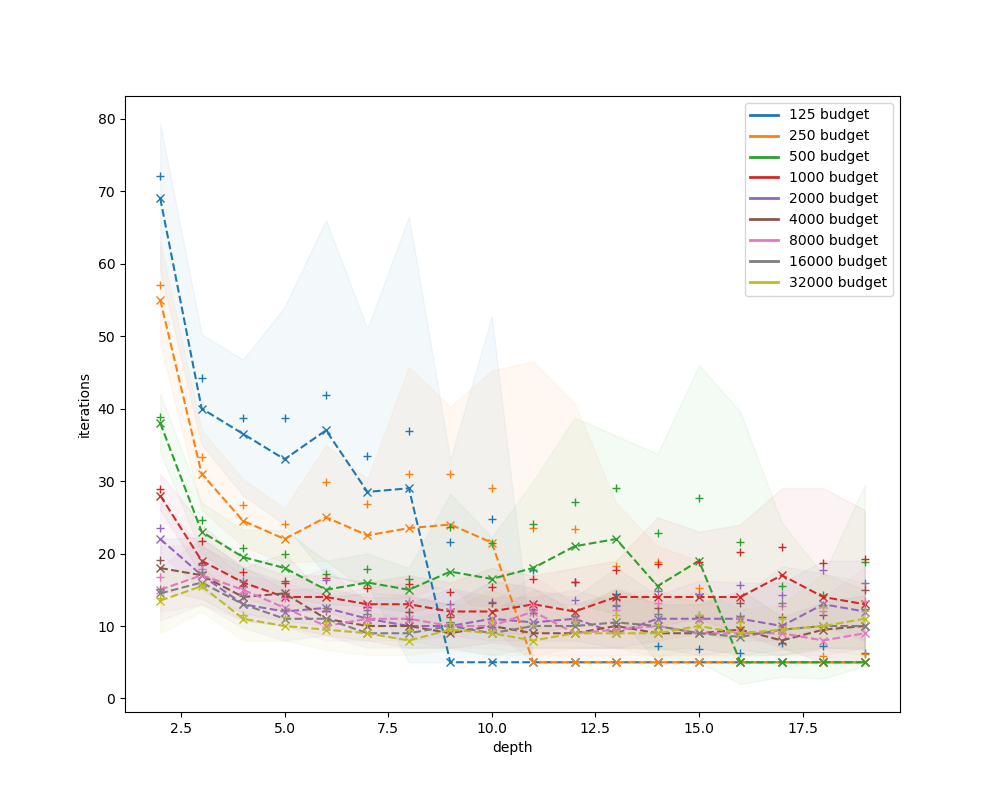

(<Figure size 1000x800 with 1 Axes>,
 <AxesSubplot:xlabel='depth', ylabel='iterations'>)

In [4]:
def generateColors(numColors, colormapName='winter'):
    cm = pyplot.get_cmap(colormapName)
    return [cm(1.*i/numColors) for i in range(numColors)]
    
def splitDataframeIntoGroups(df, cols):
    grouped = df.groupby(cols) #, as_index=False)
    return [grouped.get_group(group) for group in grouped.groups], list(grouped.groups.keys())
    
def distStats(vals):
    return vals.mean(), vals.median(), vals.quantile(.25), vals.quantile(.75)

def getSeriesStack(aggregationGroups, extractor):
    stats = []
    for aggregationGroup in aggregationGroups:
            stats.append(distStats(extractor(aggregationGroup)))
    return numpy.vstack(stats)

def plotEach(
    datasets,
    xlabel,
    ylabel,
    seriesColumns = ['budget'],
    aggregationColumns = ['depth'],
    xFunction=lambda dataset : dataset['depth'], 
    yFunction=lambda dataset : dataset['depth'],
    legendFunction= lambda groupName : '{} budget'.format(groupName),
#     plotFunction=lambda x, y, code, color : pyplot.semilogy(x,y,code, color=color),
    legend=None,
    show=True,
    yScale = 'linear',
    xScale = 'linear',
    alpha = .05,
    ):
    
    fig = pyplot.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.set_yscale(yScale)
    ax.set_xscale(xScale)
    
    pyplot.xlabel(xlabel)
    pyplot.ylabel(ylabel)
    
    series, groupNames = splitDataframeIntoGroups(datasets, seriesColumns)
    legend = list(map(legendFunction, groupNames))
#     colors = generateColors(len(series))
    colors = [pyplot.cm.tab20(i) for i in range(0,20,2)]
    for i, series in enumerate(series):
        aggregationGroups, _ = splitDataframeIntoGroups(series, aggregationColumns)
        
        x = getSeriesStack(aggregationGroups, xFunction)
        y = getSeriesStack(aggregationGroups, yFunction)
        
        color = colors[i]
#         pyplot.plot(x[:,0], y[:,0], 'x--', color=colors[i])
        pyplot.plot(x[:,0], y[:,1], 'x--', color=color)
        pyplot.plot(x[:,0], y[:,0], '+', color=color)
        pyplot.fill_between(x[:,1], y[:,2], y[:,3], color=color, alpha=alpha)
#         plotFunction(xValues, yValues, 'x--', color=colors[i])
    
    if legend is not None:
        lines = [Line2D([0], [0], color=color, lw=2) for color in colors]
        pyplot.legend(lines, legend)
    if show:
        pyplot.show()
        
    return fig, ax
        
plotEach(datasetGroups, 
         'depth',
         'iterations',
         yFunction=lambda dataset: dataset['iterations'],
        )

<IPython.core.display.Javascript object>


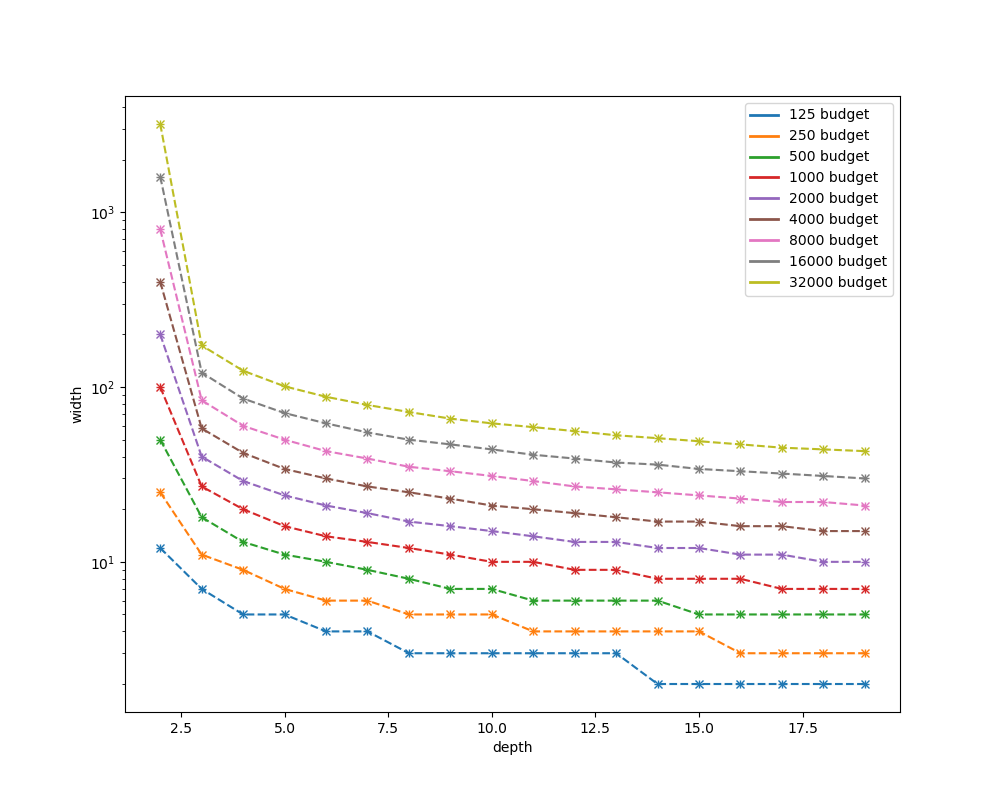

(<Figure size 1000x800 with 1 Axes>,
 <AxesSubplot:xlabel='depth', ylabel='width'>)

In [5]:
plotEach(datasetGroups, 
         'depth', 
         'width',
         yFunction=lambda dataset: dataset['width'], 
         yScale='log',
        )


<IPython.core.display.Javascript object>


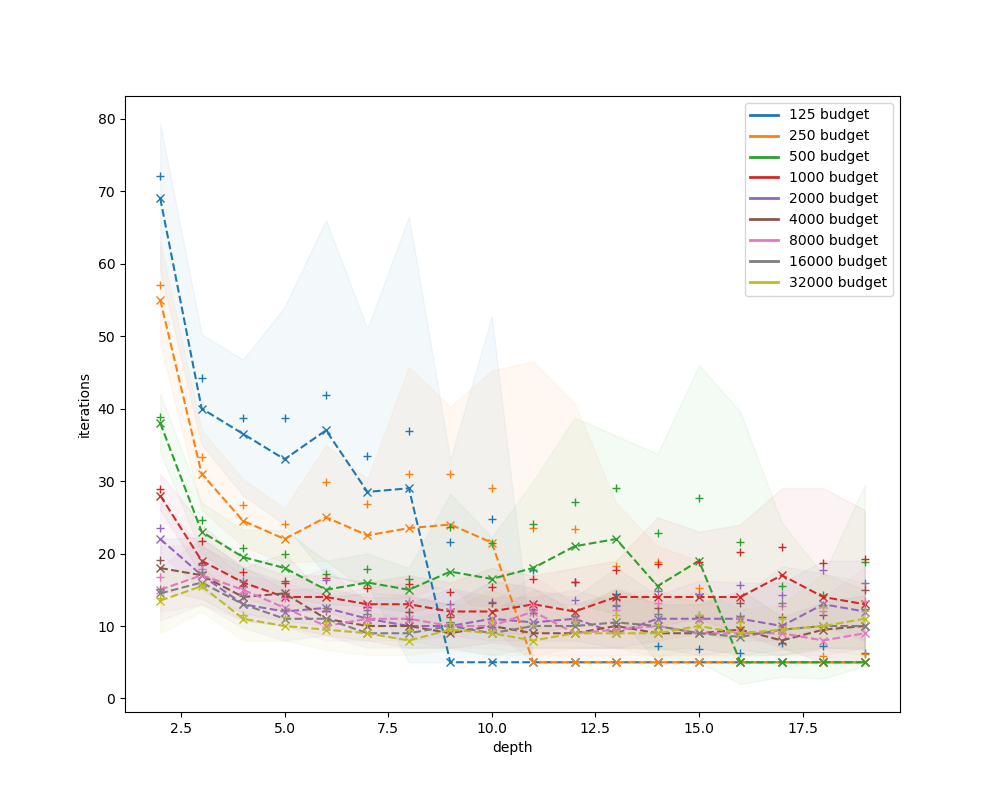

(<Figure size 1000x800 with 1 Axes>,
 <AxesSubplot:xlabel='depth', ylabel='iterations'>)

In [6]:
plotEach(datasetGroups, 
         'depth', 
         'iterations',
         yFunction=lambda dataset: dataset['iterations'], 
        )

<IPython.core.display.Javascript object>


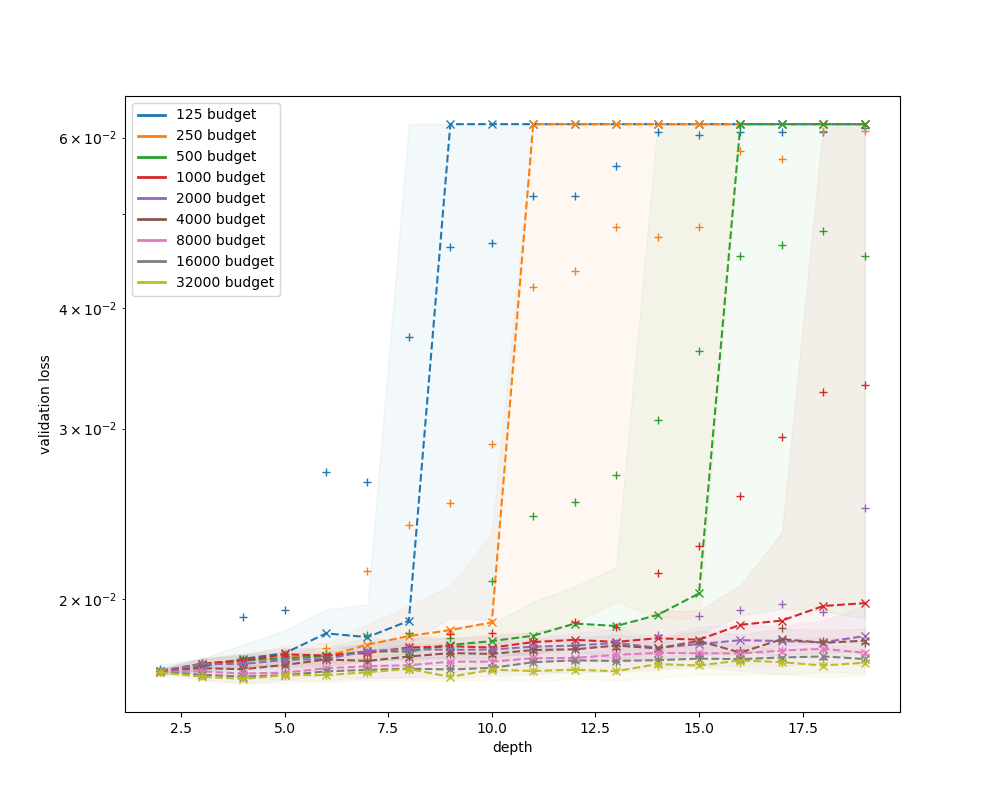

<IPython.core.display.Javascript object>


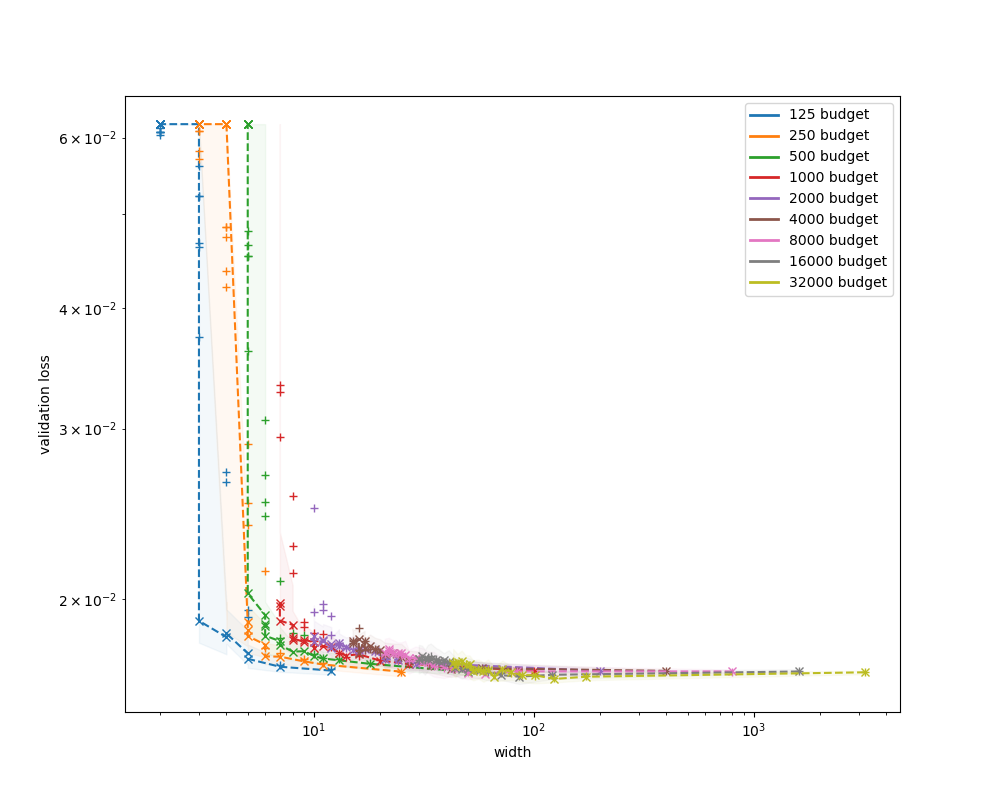

<IPython.core.display.Javascript object>


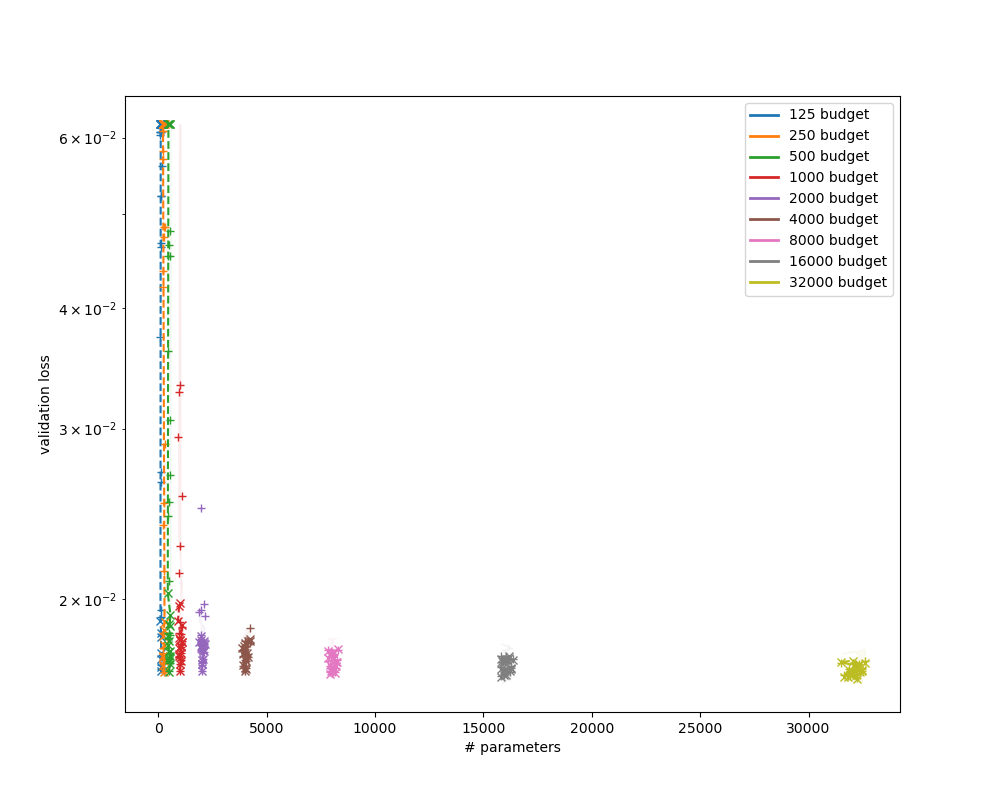

(<Figure size 1000x800 with 1 Axes>,
 <AxesSubplot:xlabel='# parameters', ylabel='validation loss'>)

In [7]:
plotEach(datasetGroups, 
         'depth',
         'validation loss',
         yFunction=lambda dataset: dataset['val_loss'], 
         yScale='log'
         )
plotEach(datasetGroups, 
         'width',
         'validation loss',
         xFunction=lambda dataset: dataset['width'], 
         yFunction=lambda dataset: dataset['val_loss'], 
         yScale='log',
         xScale='log'
         )
plotEach(datasetGroups, 
         '# parameters',
         'validation loss',
         xFunction=lambda dataset: dataset['num_weights'], 
         yFunction=lambda dataset: dataset['val_loss'], 
         yScale='log'
         )

<IPython.core.display.Javascript object>


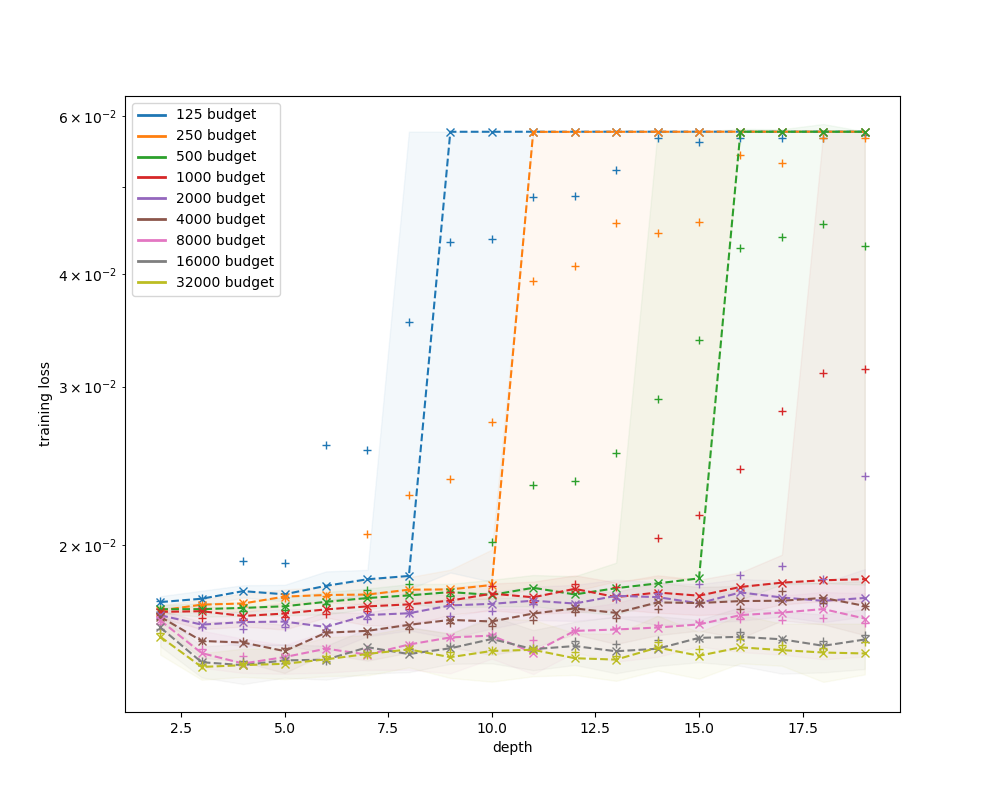

<IPython.core.display.Javascript object>


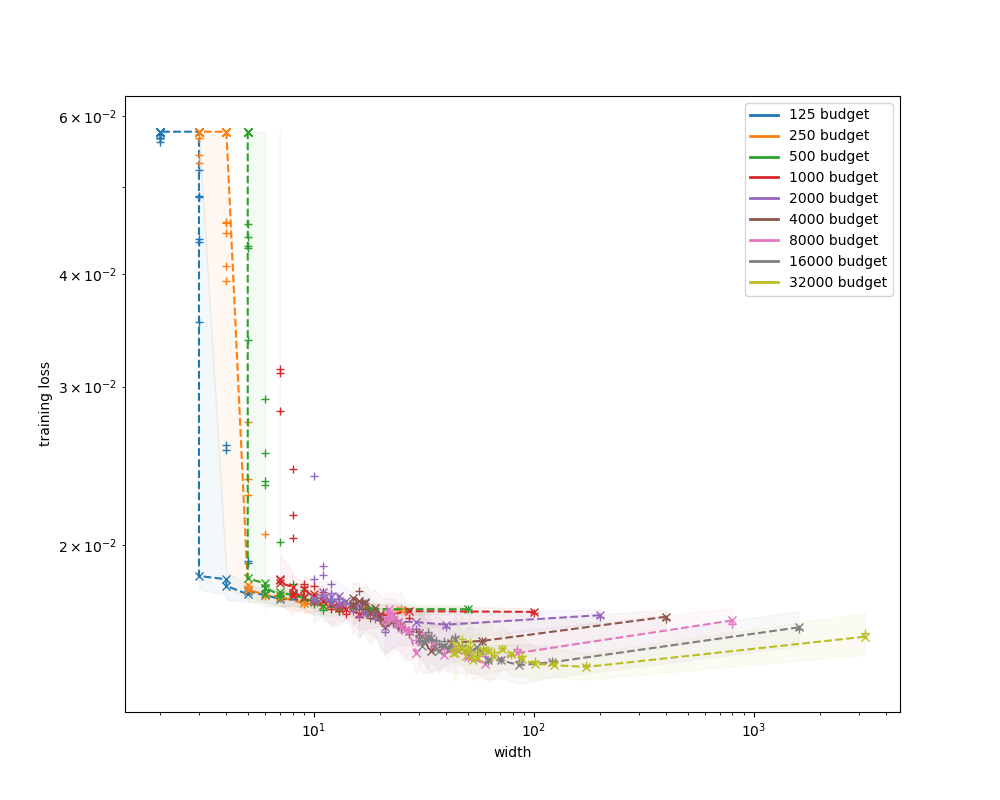

<IPython.core.display.Javascript object>


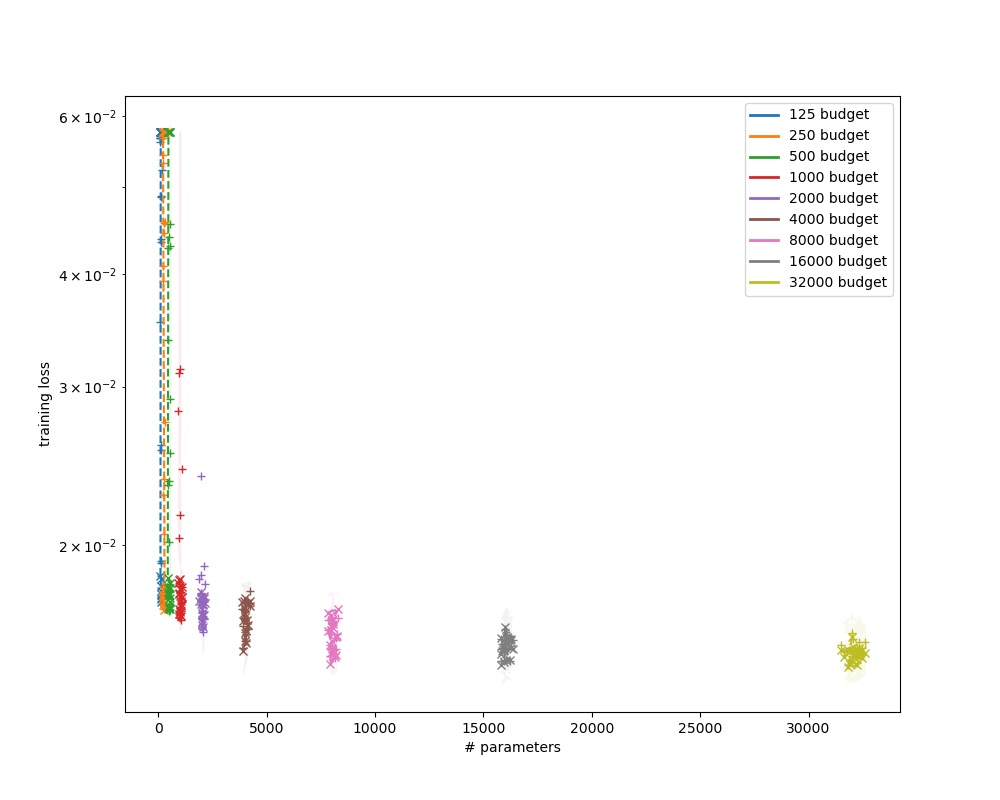

(<Figure size 1000x800 with 1 Axes>,
 <AxesSubplot:xlabel='# parameters', ylabel='training loss'>)

In [8]:
plotEach(datasetGroups, 
         'depth',
         'training loss',
         yFunction=lambda dataset: dataset['loss'], 
         yScale='log'
         )
plotEach(datasetGroups, 
         'width',
         'training loss',
         xFunction=lambda dataset: dataset['width'], 
         yFunction=lambda dataset: dataset['loss'], 
         yScale='log',
         xScale='log'
         )
plotEach(datasetGroups, 
         '# parameters',
         'training loss',
         xFunction=lambda dataset: dataset['num_weights'], 
         yFunction=lambda dataset: dataset['loss'], 
         yScale='log'
         )

<IPython.core.display.Javascript object>


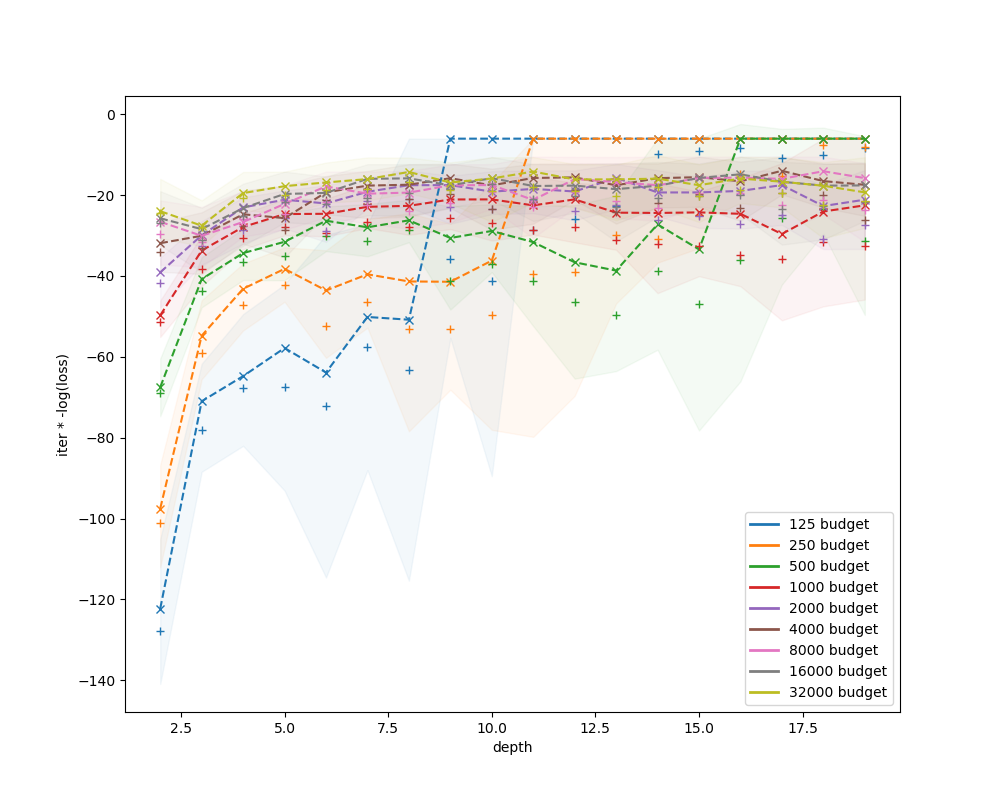

(<Figure size 1000x800 with 1 Axes>,
 <AxesSubplot:xlabel='depth', ylabel='iter * -log(loss)'>)

In [9]:
plotEach(datasetGroups, 
         'depth',
         'iter * -log(loss)',
#          xFunction=lambda dataset: dataset['iterations'],
         yFunction=lambda dataset: numpy.log(dataset['val_loss'])/numpy.log(10) * dataset['iterations'], 
         yScale='linear'
         )

<IPython.core.display.Javascript object>


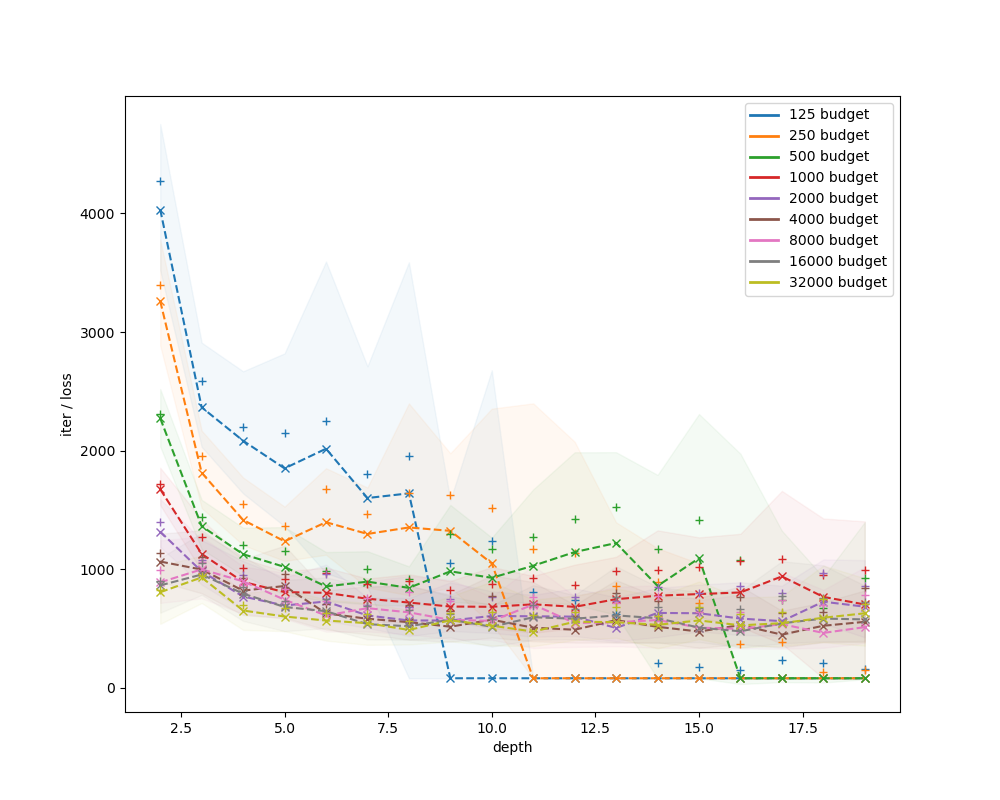

(<Figure size 1000x800 with 1 Axes>,
 <AxesSubplot:xlabel='depth', ylabel='iter / loss'>)

In [11]:
plotEach(datasetGroups, 
         'depth',
         'iter / loss',
#          xFunction=lambda dataset: dataset['iterations'],
         yFunction=lambda dataset: dataset['iterations'] / dataset['val_loss'], 
         yScale='linear'
         )

In [10]:
plotEach(datasetGroups, 
         '# weights',
         'validation loss',
         xFunction=lambda dataset: dataset['num_weights'],
         yFunction=lambda dataset: dataset['val_loss'], 
         legend=legend,
         yScale='log')


NameError: name 'legend' is not defined

<IPython.core.display.Javascript object>


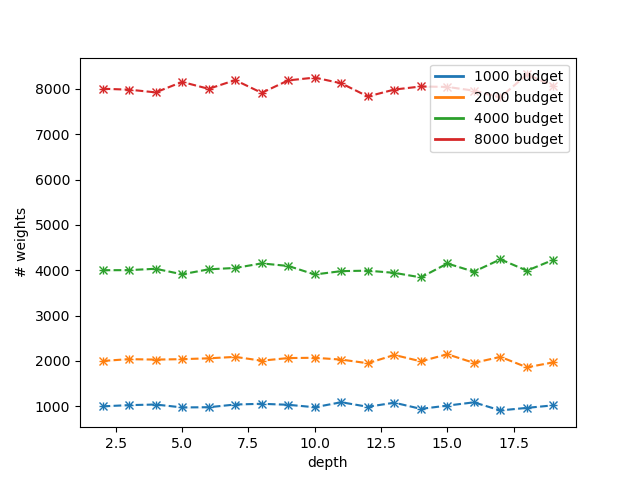

<IPython.core.display.Javascript object>


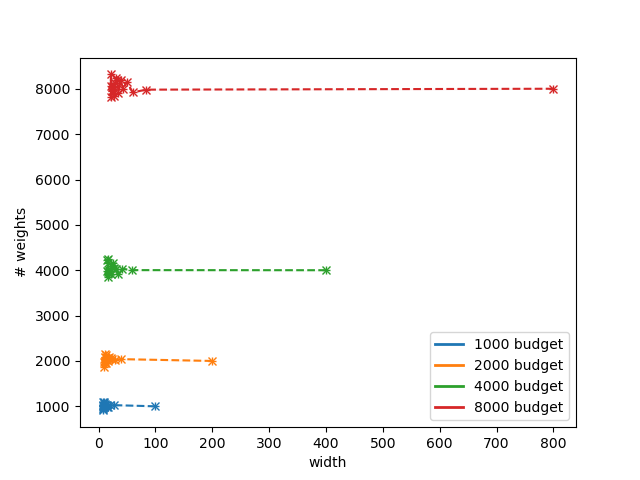

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot:xlabel='width', ylabel='# weights'>)

In [240]:
plotEach(datasetGroups, 
         'depth',
         '# weights',
         xFunction=lambda dataset: dataset['depth'],
         yFunction=lambda dataset: dataset['numWeights'], 
         )

plotEach(datasetGroups, 
         'width',
         '# weights',
         xFunction=lambda dataset: dataset['width'],
         yFunction=lambda dataset: dataset['numWeights'], 
         )

<IPython.core.display.Javascript object>


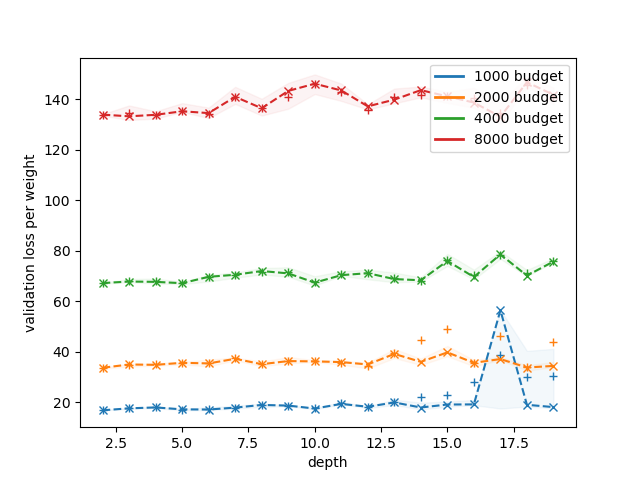

<IPython.core.display.Javascript object>


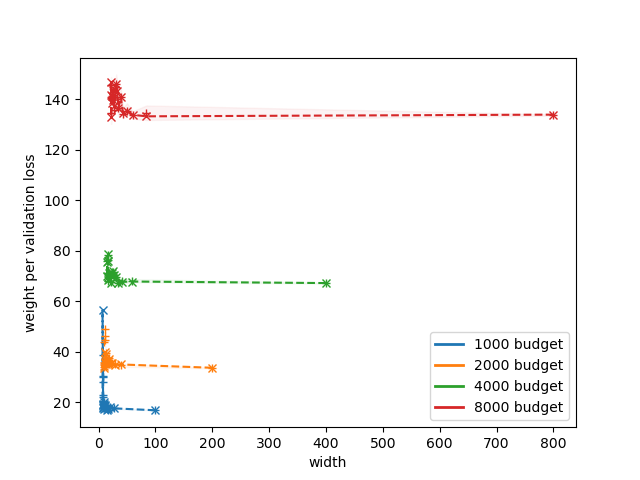

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot:xlabel='width', ylabel='weight per validation loss'>)

In [242]:
plotEach(datasetGroups, 
         'depth',
         'validation loss per weight',
         xFunction=lambda dataset: dataset['depth'],
         yFunction=lambda dataset: dataset['numWeights']*(dataset['val_loss']), 
         legend=legend)

plotEach(datasetGroups, 
         'width',
         'weight per validation loss',
#          plotFunction=lambda x, y, code: pyplot.plot(x,y,code), 
         xFunction=lambda dataset: dataset['width'],
         yFunction=lambda dataset: dataset['numWeights']*(dataset['val_loss']), 
         legend=legend)

